In [1]:
%matplotlib inline
import time
import numpy as np
import imageio
import scipy.io
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
import glob
import os
import re
from os import listdir
import matplotlib.pyplot as plt 
from matplotlib import style 
from math import sqrt
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from skimage.color import rgb2gray

In [2]:
def plt_boxData(classL, numImagesPerClass, numImages, width, length, array_data = None, WH_product = None):
    '''
    Plot the first five sample images of the dataset in each class.
    It will give 25 plots in total.
    Parameters
        ----------
        classL: list, list of class labels. Starting from 0
        numImagesPerClass: list, relating to classL: image number per corresponding class
        numImages: int, total number of images in image dataset
        width: int, single image row dimension
        length: int, single image column dimension
        array_data: 3D array-like, stacked classes with shape = (numImg, imgWidth, imgLength)
        WH_product: nd array, W*H product, . Need to be reshped for plotting
        
    Returns
        -------
        none
    '''
    try:
        img_all = np.reshape(WH_product.T, (numImages,width,length))
    except Exception:
        img_all = array_data

    for i in classL:
        fig, axarr = plt.subplots(1, 5, figsize=(11, 11))
        for ax, n in zip(axarr.flatten(), np.arange(5)):
            if i!=0:
                idx = sum(numImagesPerClass[:i])+n
            else:
                idx = n
            ax.imshow(img_all[idx+5], cmap='gray')
            ax.set_title("%i. " % (n+1) + "Class %i"  % (i+1), fontsize=13)
        plt.show()
        
def splitX(X, classL, numImagesPerClass):
    '''
    Split data matrix X into classes matrix for performing Kmeans on each class
    Parameters
        ----------
        X: 2D array, shape = (total number of images, image dimension)
        classL: list, list of class labels. Starting from 0
    Returns
        -------
        X_class: list of arrays, splitted
    '''
    X_class = []
    # split features based on classes
    for i in classL:
        if i!= 0:
            cur_idx = sum(numImagesPerClass[:i])
            next_idx = cur_idx + numImagesPerClass[i]
        else:
            cur_idx = 0
            next_idx = numImagesPerClass[i]
            
        X_class.append(X[:, cur_idx:next_idx])
        
    return X_class
def initialise_WH(width, length, kmeans, NumOfClasses, k_clusters):
    '''
    Initialisation of W and H
        ----------
        kmeans: 1D list of kmeans classifiers
        classL: list, list of class labels. Starting from 0
    Returns
        -------
        W_init: nd array
        H_init: nd array
    '''
    # Extract kmeans centres of each class and stack them into W_init
    W_init = np.zeros((width*length, NumOfClasses*k_clusters))
    for i in np.arange(NumOfClasses):
        W_init[:, i*k_clusters:(i+1)*k_clusters] = kmeans[i].cluster_centers_.T
    
    np.random.seed(20)
    H_init = np.random.uniform(0.0, 1.0, size = (NumOfClasses*k_clusters, numImages))

    # Make sure all the centroids are nonnegative
    W_init[W_init<0.00001] = 0
    return W_init, H_init

def nmf_singleClass(NumOfClasses, X_class, k_clusters, alpha = 0, l1_ratio = 0):
    '''
    Run Non-negative matrix factorization for each classes.
    Assign the updated W and H into a list.
    Parameters
        ----------
        NumOfClasses: int
        k_clusters: int, should be less than image dimension. Selected by elbow's method
    Return:
        ----------
        W_class: list of arrays, contains W for each class
        H_class: list of arrays, contains H for each class
    
    '''
    # Individual class nmf
    NMFmodel = []
    W_class = []# np.zeros((NumOfClasses, width*length, k_clusters))
    H_class = []# np.zeros((NumOfClasses, k_clusters, numImages))

    for i in np.arange(NumOfClasses):
        NMFmodel = NMF(n_components=k_clusters,init='nndsvd', solver='mu', 
                            beta_loss='frobenius', tol=0.0001, max_iter=500, 
                            random_state=None, alpha = alpha, l1_ratio = l1_ratio)


        W_class.append(NMFmodel.fit_transform(X_class[i]))
        H_class.append(NMFmodel.components_)
    del NMFmodel
    return W_class, H_class

def nmf_allClass(NumOfClasses, k_clusters, W_init, H_init, alpha=0, l1_ratio =0):
    '''
    Run Non-negative matrix factorization for each classes.
    Assign the updated W and H into a list.
    Parameters
        ----------
        NumOfClasses: int
        k_clusters: int, should be less than image dimension. Selected by elbow's method
    Return:
        ----------
        W_all: 2d array, updated W for all classes. shape = (image dimension, num of components)
        H_all: 2d array, updated H for all classes. shape = (num of components, total num of sample)
    '''
    # Used kmeans centroid as W and H initialisation. Use nmf package for updating W and H.
    n_components = NumOfClasses*k_clusters
    modelTest1 = NMF(n_components= n_components, init='custom', solver='mu', 
                     beta_loss='frobenius', tol=0.0001, max_iter=500, 
                     random_state=None, alpha = alpha, l1_ratio = l1_ratio)

    W_all = modelTest1.fit_transform(X, W = W_init, H = H_init)
    H_all = modelTest1.components_
    del modelTest1
    return W_all, H_all

def stack_singleWH(W_class, H_class, NumOfClasses,numImagesPerClass, k_clusters):
    '''
    Stack each class of updated W hozizontally and updated H diagonally for processing
    Parameters
        -----------
        W_class: list of arrays, contains W for each class
        H_class: list of arrays, contains H for each class
    Return
        ----------
        W_conc: nd array, shape = (single image dimension, components number)
        H_conc: nd array, shape = (components number, number of total dataset samples)
    
    '''
    W_conc = np.zeros((width*length, k_clusters*NumOfClasses))
    H_conc = np.zeros((k_clusters*NumOfClasses, numImages))

    for i in np.arange(NumOfClasses):
        if i!=0:
            cur_idx = sum(numImagesPerClass[:i])
            next_idx = cur_idx + numImagesPerClass[i]
        
        else:# i==0
            cur_idx = 0
            next_idx = numImagesPerClass[i]
        W_conc[:, i*k_clusters:(i+1)*k_clusters] = W_class[i]
        H_conc[i*k_clusters:(i+1)*k_clusters, cur_idx:next_idx] = H_class[i]
    return W_conc, H_conc

def replace_Hall_with_Hclass(H_all, H_class, NumOfClasses, numImagesPerClass, k_clusters):
    ''' 
    Stack single class of Hclass result onto all class result H_all
    Concatenate W and H to to facilitate stacked calculation
    
    Parameters
        ----------
        H_all: nd array, updated H for the whole dataset. shape = (components number, total num of sample)
    Return:
        ----------
        H_concat: nd array, shape = (components number, number of total dataset samples)
    '''
    H_concat = H_all.copy()
    for i in np.arange(NumOfClasses):
        if i!=0:
            cur_idx = sum(numImagesPerClass[:i])
            next_idx = cur_idx + numImagesPerClass[i]
        else:# i==0
            cur_idx = 0
            next_idx = numImagesPerClass[i]
        H_concat[i*k_clusters:(i+1)*k_clusters, cur_idx:next_idx] = H_class[i]
    return H_concat

def normalizeColumns(matrix):
    '''
    normalizes the input matrix to have the L1 norm of each column = 1
    Parameter
        ----------
        matrix: nd array
    '''
#     output = np.zeros((matrix.shape))
    for i in range(matrix.shape[1]):
#         output[:,i] = np.divide(matrix[:,i], sum(abs(matrix[:,i])))
        matrix[:,i] = np.divide(matrix[:,i], sum(abs(matrix[:,i])))
    return matrix #output
def projection(s, L1, L2sqr, nonNeg, set_sparsity):
    '''
    Projection operator that imposes sparseness
    by explicitly setting both L1 and L2 norms (and enforcing non-negativity).

    '''
#     nonNeg = True #non-negativity constraint flag. 
#     i = 2
#     s = mat[:, i] # col
#     L1 = L1toL2 * L2W_norm[i]
#     L2sqr = L2W_norm[i]**2
    # Number of feature
    N = len(s)

    try: 
        nonNeg
    except NameError: 
    #     nonNeg = None
#         print('non-negativity flag is not set')
        isneg = s<0 # save column negativity state
        s = abs(s) # take absolute of the colume.

    # projecting the point to the sum constraint hyperplane
    v = s + (L1-sum(s))/N
    # Initialize an array for zero valued components
    zerocoeff = []
    j = 0
    while 1:
        midpoint = np.ones((N,1))*L1/(N-len(zerocoeff))#  projection operator by Hoyer(2004)
        midpoint[zerocoeff] = 0
        midpoint=np.reshape(midpoint,(len(midpoint),))
        w = v-midpoint
        a = sum(w**2)
        # b = 2*w.T*v
        b = 2*w@v
        c = round(sum(v**2)-L2sqr, 5) 
        alphap = (-b+np.real(sqrt(b**2-4*a*c)))/(2*a)
        v = alphap*w + v
#         print('c: ',c) # Why is c always zero?
        if all(vv>=0 for vv in v):
            # Solution found
#             print('All elements in v are non-negative')
            itrations = j+1
            break
        j += 1

        # Set negs to zero, subtract appropriate amount from rest
        zerocoeff = np.where(v<=0)
    #     print("Replace the negative values of the array with 0")
        v[v <= 0] = 0
        tempsum = sum(v)
        v = v + (L1-tempsum)/(N_p-len(zerocoeff)) #Calculate c := (sum(s)−L1)/(dim(x)−size(Z))
        v[v <= 0] = 0
        new_sparsity = sum(v==0)/len(v)
        if new_sparsity > set_sparsity:
    #         zerocoeff =  np.where(v<=0)
            v[v <= 0] = 0
            itrations = j
#             print('WARNING: sparsity contraint function does not converges')
            break
    # sum(v.^2)=k2 which is closest to s in the euclidian sense
    try: 
        nonNeg
    except NameError: 
    #     nonNeg = None
        print('Return v\'s original sign')
    #     (-2*isneg + 1) make the non-nagative element index  -1
        v = np.multiply((-2*isneg + 1), v) # Return original signs to solution
    if any(abs(v.imag))>1e-5:
        print('ERROR: you have imaginary values!')
    del zerocoeff, a, b, c, w, s, tempsum, alphap
    return v, itrations
def sparcify_columns(mat, set_sparsity):
    # sparsify_columns.m
#     mat = W_init 

    #     Number of pixel
    N_p = len(mat)
    #  desired L1 to L2 ratio to acheive sparsity level:
    L1toL2 = sqrt(N_p) - sqrt(N_p-1)*set_sparsity # L1L2ratio
    #L2 norms of columns of matrix
    L2W_norm = np.linalg.norm(mat, axis = 0) #L2W
    #     Apply sparseness constraints on W_init
    i = 1
    # col = mat[:, i]
    # L1W_norm = L1toL2*L2W_norm[i]
    # projection(col, L1W_norm, L2W_norm[i]**2, True, set_sparsity)
    start = time.time()
    for i in range(0, mat.shape[1]):
        col = mat[:, i]
    #     set colume to achieve desired sparseness 
        L1W_norm = L1toL2*L2W_norm[i]
        scol, itr = projection(col, L1W_norm, L2W_norm[i]**2, True, set_sparsity)
    #     update:
        mat[:, i] = scol
        del scol
#     sparse_matrix = mat
    end = time.time()
    print("Elapsed time for applying sparseness constraint:", 
                                             end - start, 'seconds.') 
    del L2W_norm, start, end, N_p
    return mat

In [4]:
mypath = 'C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/ContenSimilarityTest/images_Landmass.mat'
# Draw raw
list_data = scipy.io.loadmat(mypath)['images']
array_data = np.array(list_data)
NumOfClasses = 4
classL = [0, 1, 2, 3]
# numImages is total num of images
numImages = array_data.shape[0]
# Same number of images per class
numImagesPerClass = [500, 500, 500, 500]
# Image shape:(width, length)
width = array_data[0].shape[0]
length = array_data[0].shape[1]
del list_data, mypath
# Plot the first 5 data image in gray scale
# plt_boxData(classL, numImagesPerClass, numImages, width, length, array_data = array_data)

In [5]:
# reshape data matrix for NMF input
X = np.reshape(array_data,(numImages,width*length)).T
print('Data matrix X shape: ', X.shape)
# Check if there is negative element in the matrix. The dataset should be normalised to [0, 1]
if (X < 0).any():
    print('Matrix elements are not all positive!')

Data matrix X shape:  (9801, 2000)


In [6]:
X_class = splitX(X, classL, numImagesPerClass) # 
k_clusters = 250

In [7]:
kmeans = []
# Perform kmeans on each dataset features
for i in np.arange(NumOfClasses):
    kmeans.append(KMeans(n_clusters=k_clusters, max_iter=1000).fit(X_class[i].T))

In [8]:
# W_class, H_class = nmf_singleClass(NumOfClasses, X_class, k_clusters, alpha = 0.0, l1_ratio = 0)
del X_class

In [9]:
# Initialise W and H for the whole dataset
W_init, H_init = initialise_WH(width, length, kmeans, NumOfClasses, k_clusters)

In [10]:
N_p = len(X)
set_sparsity = 0.4 #0.6, 0.8
L1toL2 = sqrt(N_p) - sqrt(N_p-1)*set_sparsity # L1L2ratio
# W_init = sparcify_columns(W_init, set_sparsity)

In [11]:
W_all, H_all = nmf_allClass(NumOfClasses, k_clusters, W_init, H_init, alpha = 0.1, l1_ratio = L1toL2)
del W_init, H_init

In [ ]:
# W_class, H_class = nmf_singleClass(NumOfClasses, X_class, k_clusters, alpha = 0.0, l1_ratio = 0)
# del X_class

In [ ]:
WH_product = np.dot(W_class[1], H_class[1])
img_all = np.reshape(WH_product.T, (500, width,length))
plt.imshow(img_all[1])
del WH_product

In [ ]:
W_conc, H_conc = stack_singleWH(W_class, H_class, NumOfClasses, numImagesPerClass, k_clusters)

In [ ]:
H_concat = replace_Hall_with_Hclass(H_all, H_class, NumOfClasses, numImagesPerClass, k_clusters)

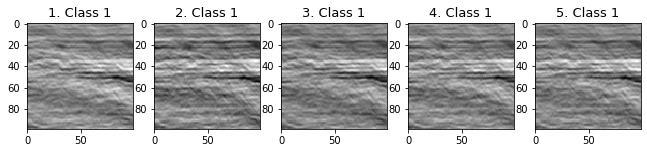

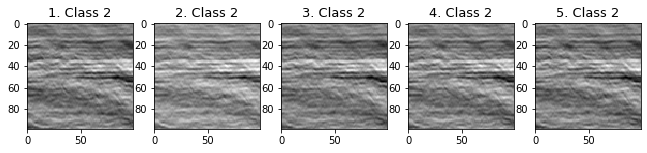

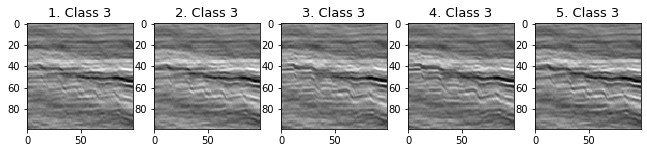

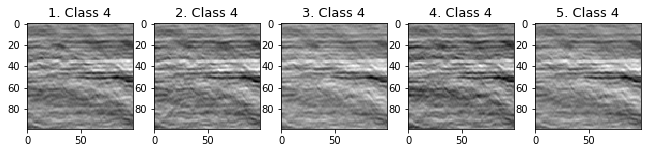

In [16]:
WH_product = np.dot(W_all, H_all)
plt_boxData(classL, numImagesPerClass, numImages, width, length, WH_product = WH_product)
del WH_product

In [14]:
def plotHistogram_W(W_, name_):
    '''
    Plot Histogram of basis matrix.
    The histogram indicates disdributions of each geophysical feature magnitude.
    
    W_ : numpy array of basis matrix W
    name_: numpy array of string
    eg.     W_ = np.array([W1, W2])
            name_ = np.array([name1, name2])
    
    '''
    f, axs = plt.subplots(1,2, figsize=(15,3))
    im = np.arange(2) # Plot distribution of two W
    
    for n, W, name in zip(im, W_, name_):
        w = np.zeros((NumOfClasses, W.shape[0]*k_clusters))
        W_flat = np.reshape(W, (W.shape[0]*W.shape[1],))
        for i in np.arange(NumOfClasses):
#             Assign classes of w into w[i] for plotting
            w[i] = W_flat[W.shape[0]*k_clusters*i : W.shape[0]*k_clusters*(i+1)]

            # You can normalize it by setting 
            # density=True and stacked=True. By doing this the total area under each distribution becomes 1.
            # e.g: dict(density=True, stacked=True)
            kwargs = dict(alpha=0.35) # Set opacity

            axs[n].hist(w[i], **kwargs, label= 'Class %i'%(i+1) )
        del w, W_flat
        axs[n].set_title('Frequency Histogram of '+ name)
        axs[n].set_xlabel('Seismic Feature Magnitude',fontsize=14)
        axs[n].set_ylabel('Frequency',fontsize=14)
        axs[n].legend(prop={'size': 14})
    plt.show()
    print('The above histograms show distibution of features in two different basis matrices W')
    f.savefig('W_Histograms')
    del f
    return 

def plotH(numPlot, H_all, H_class, target_classL, imgIdx, k_clusters):
    '''
    Plot feature coefficient matrix only for a quick observation
    Parameter
        -----
        numPlot: int, number of plot you want to have. Suggest plot number <= 4
        target_classL: int, target class label you would like to demonstrate. should be one of the number in 'classL'
        imgIdx: int, starting index of the plot
    '''
    x = np.arange(k_clusters)
    f, axs = plt.subplots(1,numPlot, figsize=(17,3.5))
    for ii in range(numPlot):
        if target_classL!=0:
            tarIdx = sum(numImagesPerClass[:target_classL])+imgIdx+ii # Target index
        else:
            tarIdx = imgIdx+ii # Target index
        y1 = H_all[target_classL*k_clusters:(target_classL+1)*k_clusters, tarIdx]
        y2 = H_class[target_classL][:, imgIdx+ii]
       
        lg1, = axs[ii].plot(x, y1, 'bx', label='Stacked H')
        lg2, = axs[ii].plot(x, y2,'r.', label = 'Single H')
        axs[ii].set_xlabel("Index of feature")
        axs[ii].set_ylabel("Magnitude")
        axs[ii].set_title("Img%i.Class%i feature coeeficient."%(tarIdx, target_classL+1),fontsize=13)
        axs[ii].legend(handles=[lg1, lg2], loc = 'best',fontsize=11)
    f.savefig('H .jpg')
    del f
    return

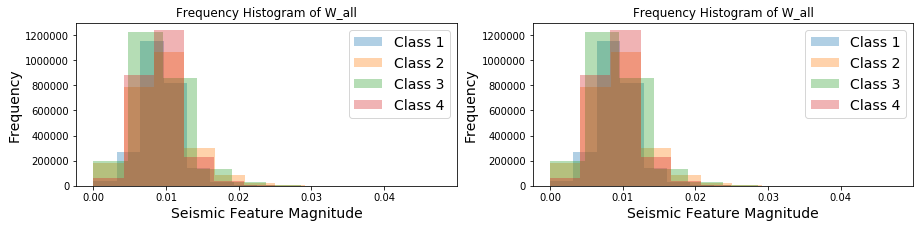

The above histograms show distibution of features in two different basis matrices W


IndexError: too many indices for array

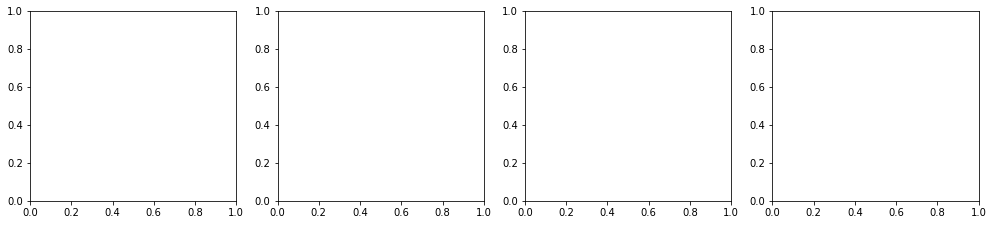

In [15]:
# Plot histogram of single class updated W and all classes updated W
W_ = np.array([W_all, W_all])
name_ = np.array(['W_all', 'W_all'])
plotHistogram_W(W_,name_)
#  Plot different H for observation and analysis
target_classL = 3
imgIdx = 0
plotH(4, H_all, H_all, target_classL, imgIdx, k_clusters)

In [17]:
def get_likelihoodMatrix(W_stk, H_stk, NumOfClasses, k_clusters, numImages, width, length):
    '''
    Get the likelihood matrix of the nmf data matrix. 
    Each pixel is a seismic structure in W. 
    The likelihood matrix Y indicates the likelihood of each pixel being that structure
    
    Parameter
        ----------
        W_stk: nd array, updated W with stacked result. shape = (single image dimension, components number)
        H_stk: nd array, updated H with stacked result. shape = (components number, number of total dataset samples)
    Return
        ----------
        Y: nd array, likelihood matrix
    '''
    Qr = np.kron(np.eye(NumOfClasses, NumOfClasses), np.ones((k_clusters,1)))
    Qr = normalizeColumns(Qr)
    Y = np.zeros((numImages, width*length, NumOfClasses))
    N_class = np.ones((1,NumOfClasses))

    for img in range(0, numImages):
        Hi = np.reshape(H_stk[:,img],(len(H_stk[:,img]),1))
        # map the coefficients of each image into the seismic structures that make up that image
        # Each Y shows the likelihood of each seismic structure for each pixel in the image.
        H_l = np.dot(Hi,N_class)
        WH_i = np.dot(W_stk, np.multiply(Qr, H_l))
    #     print('len(WH_product)',len(WH_product))
        Y[img,:, :] = WH_i
        
    return Y
def extract_coordination(Y, NumOfClasses, numImages, width, length, bkgrd_label,
                         gaussian_filtering = True, median_filtering = True, sigma = 0.5):
    '''
    Get the likelihood matrix of the nmf data matrix. 
    Each pixel is a seismic structure in W. 
    The likelihood matrix Y indicates the likelihood of each pixel being that structure
    
    Parameter
        ----------
        W_stk: nd array, updated W with stacked result. shape = (single image dimension, components number)
        H_stk: nd array, updated H with stacked result. shape = (components number, number of total dataset samples)
    Return
        ----------
        classified_all: nd array, classification matrix. Shape = (total num of data, width, length)
    '''
    if gaussian_filtering:
    #     Filter each image
        for n in np.arange(numImages):
            Y_n = np.zeros((width,length))
            Y_n = Y[n, :, :]
            for label in range(NumOfClasses):
                temp = np.reshape(Y_n[: ,label].T,(width,length))
                temp = gaussian_filter(temp, sigma)
                Y[n, :,label] = np.reshape(temp,(length*width,))
            del Y_n

    # Get the maximun value of each row 
    vals= np.max(Y,axis = 2)
    #  Using vals to show which area has more confidence
    # devided by sum of each row
    conf = np.divide(vals, np.sum(Y,axis = 2)+1e-5)
    # Get the column index of maximum value. The index indicate which class the pixel falls in.
    classImg = np.argmax(Y,axis = 2)

    classified_all = np.zeros((numImages, width, length))
    if median_filtering:
        #     Filter each image
        for n in np.arange(numImages):
            img = np.reshape(classImg[n], (length, width))
            classified_all[n] = median_filter(img,size = (3,3), mode = 'reflect')
            del img

    # Turn all the low confidence pixels to bkgrd_label class
    std = np.std(conf, axis = 1)
    threshold = np.mean(conf, axis = 1)+std/2.9 # 3.1 can be tuned

    # Turn all the low confidence pixels to other class, class 5
    # Reshape confidence values into data matrix's dimension
    conf = np.reshape(conf, (numImages, length, width))
    
    # loop through all the images to get the classification mask
    for n in np.arange(numImages):
        classified_all[n][conf[n]<threshold[n]] = bkgrd_label 
        
    del classImg, threshold, conf, vals
    return classified_all
def split_labelResult(classified_all, background=True):
    ''' 
    To split the classification result into individuals.
    Return
        ----------
        classN: list of arrays. Contain class of labels corrdinations
    '''
    classN = []
    for i in np.arange(NumOfClasses):
        classN.append(np.where(classified_all==i))
    if background:
        classN.append(np.where(classified_all==bkgrd_label))
    return classN
def plotLabels(classL, numImagesPerClass,numImages, width, length, classN, array_data, colorarr,plot = True):
    temp1 = np.zeros((numImages, width, length, 3)) # 3 channels
    color_img = np.uint8(temp1)
    for i in np.arange(len(classN)):
        color_img[classN[i][0], classN[i][1], classN[i][2], :] = colorarr[i]

    if plot:
        # Plot original images with masks
        for i in classL:
            fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
            for ax, n in zip(axarr.flatten(), np.arange(5)):
                if i!=0:
                    idx = sum(numImagesPerClass[:i])+n
                else:
                    idx = n
                ax.imshow(array_data[idx+5], cmap='gray')
                ax.imshow(color_img[idx+5], alpha=.4)
                ax.set_title("%i. " % (n+1) + "Class %i"  % (i+1), fontsize=13)
            plt.show()
    del fig, axarr
        
    return color_img

In [18]:
# Generate likelihood matrix 
Y = get_likelihoodMatrix(W_all, H_all, NumOfClasses, k_clusters, numImages, width, length)


In [19]:
background = True # Choose if the label includes 'background', background indicates no traps
if background:
    bkgrd_label = NumOfClasses+1 
else:
    bkgrd_label = NumOfClasses-1
bkgrd_label

5

In [20]:
classified_all = extract_coordination(Y, NumOfClasses, numImages, width, length, bkgrd_label,
                         gaussian_filtering = True, median_filtering = True, sigma = 0.9)
del Y

In [21]:
classN = split_labelResult(classified_all, background=True)

In [22]:
# blue chaotic; light blue unkown; green fault ; red salt; grey background
colorarr = np.array([[0,0,255],[100,255,255], [0,255,0], [255,0,0], [183,183,183]])

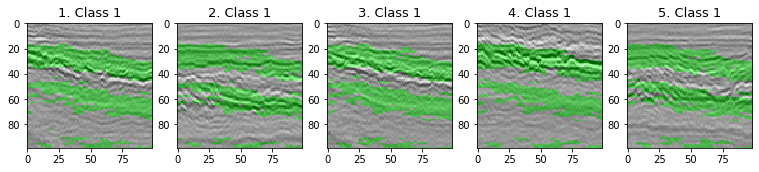

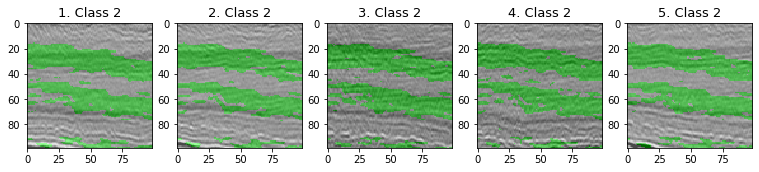

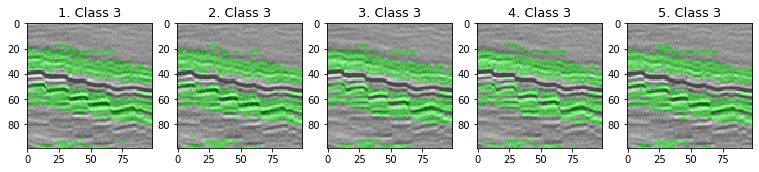

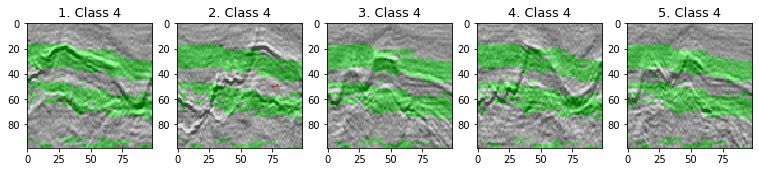

In [23]:
color_img = plotLabels(classL, numImagesPerClass,numImages, width, length, classN, array_data, colorarr)

### Validation

In [ ]:
def importMask(width, length):
    '''Import mask png files. The ground truth mask should have the same dimension with the box image'''
    # Import mask
    chaotic_path ='C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/ContenSimilarityTest/ground truth/chaotic mask/mask_ch'
    fault_path ='C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/ContenSimilarityTest/ground truth/fault mask/mask_fa'
    salt_path ='C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/ContenSimilarityTest/ground truth/salt mask/mask_sa'
    path = [chaotic_path,fault_path,salt_path]

    files = []
    for p in path:
        # Assume each class has the same number of mask
        fileList = glob.glob(p + "/*.png")
        fileList.sort(key = lambda sortNum: int(re.sub('\D', '', sortNum)))
        files.append(fileList)
    del fileList
    mask_truth = np.zeros((len(files),len(files[0]), width, length))
    n = 0

    for f in files:
        for path_m, k in zip(f, range(len(files[0]))):
            im = imageio.imread(path_m)
            mask_truth[n][k] = rgb2gray(im) # Turn RGB to gray scale
        n+= 1
    del path_m, k
    mask_truth[mask_truth>0] = 1
    maskNum = len(files[0])
    print('There are', maskNum , ' mask for each class.')
    del files
    return mask_truth, maskNum

def plotPredvsGT(numImagesPerClass, array_data, color_img, classL_acc, maskNum, imgIdx = 0):
    '''Plot prediction vs ground truth mask'''
    if imgIdx > maskNum :
        imgIdx = maskNum-1
    print('Showing the %i'%imgIdx,'image with predicted mask and ground truth.')
    for n, c in zip(range(maskNum), classL_acc):
        fig, ax = plt.subplots(1, 2, figsize=(5, 5))
        if n!=0:
            idx = sum(numImagesPerClass[:c])+imgIdx
        else:
            idx = n+imgIdx
        ax[0].imshow(array_data[idx], cmap='gray')
        ax[0].imshow(color_img[idx], alpha=.4)
        ax[0].set_title("%i. " % (n+1) + "Class %i  " %(c+1), fontsize=14)
        ax[1].imshow(mask_truth[n][imgIdx], cmap='gray')
        ax[1].set_title("%i. " % (n+1) + "Ground truth ", fontsize=14)
        fig.savefig('PredvsTruth%i.jpg'%(c+1))
        del fig
    return

In [ ]:
# Import mask
mask_truth, maskNum = importMask(width, length)

In [ ]:
classL_acc = [0, 2, 3] # Class labels for accuracy test
imgIdx = 15
plotPredvsGT(numImagesPerClass, array_data, color_img, classL_acc, maskNum, imgIdx)

In [ ]:
 def get_Ypred_Ytrue(mask_truth, classL_acc, classified_all, maskNum, bkgrd_label, background = True):
    # We don't validate unkown class's accuracy. Just class 1, 3, 4
    # Class1 label = 0, Class2 label = 1,Class3 label = 2, Class4 label = 3
    mask_pred  = []
    for c in classL_acc:
        
        pred = classified_all[sum(numImagesPerClass[:c]):sum(numImagesPerClass[:c])+ maskNum]
        pred[pred == c] = 1
        # Convert background label to zeros
        if background:
            pred[pred == bkgrd_label] = 0
        mask_pred.append(pred)
   
    y_truth = np.zeros((len(mask_truth), maskNum, width*length))
    y_pred = np.zeros((len(mask_truth), maskNum, width*length))
    for n in range(len(mask_truth)):
        for ii in range(maskNum):
            y_truth[n,ii,:] = mask_truth[n][ii].flatten()
            
            y_pred[n,ii,:] = mask_pred[n][ii].flatten()
    del mask_pred        
    return y_truth, y_pred


In [ ]:
y_truth, y_pred = get_Ypred_Ytrue(mask_truth, classL_acc, classified_all, maskNum, bkgrd_label)
del mask_truth

In [ ]:
jacc_score = np.zeros((len(classL_acc)))
cf = np.zeros((len(classL_acc)))
for n in range(len(classL_acc)):
        try:
            jacc_score[n] = jaccard_score(y_truth[n].flatten(), y_pred[n].flatten(), average = 'binary')
        except Exception:
            jacc_score[n] = jaccard_score(y_truth[n].flatten(), y_pred[n].flatten(), average = 'micro')
        cf[n] = accuracy_score(y_truth[n].flatten(), y_pred[n].flatten())
print('Jaccard score:', jacc_score)
print('Accuracy score: ',cf)

### After performing Kmeans, run the following code for validation

In [ ]:
mask_truth, maskNum = importMask(width, length)

# Jaccard Score
#  intersection of binary images y_predict and y_true divided by the union of BW1 and BW2
classL_acc = [0, 2, 3] # Class labels for accuracy test. We only validate 0, 2, 3 class
iteration = 5

jacc_score = np.zeros((iteration, len(classL_acc)))
cf = np.zeros((iteration, len(classL_acc)))

sparsity_opt = np.linspace(0.4, 0.5, num = iteration)
alpha_opt = np.linspace(0.01, 0.2, num = iteration)
# sigma_opt = np.linspace(0.2, 1, num = iteration)
for itr in range(iteration):
    # Set Sparsity
    N_p = len(X)
    set_sparsity = 0.44
    L1toL2 = sqrt(N_p) - sqrt(N_p-1)*set_sparsity # L1L2ratio
    alpha = alpha_opt[itr]
    #     RunNMF
    W_init, H_init = initialise_WH(width, length, kmeans, NumOfClasses, k_clusters)
    
    #     Sparsify columns for W_init
    W_init = sparcify_columns(W_init, set_sparsity)
    W_all, H_all = nmf_allClass(NumOfClasses, k_clusters, W_init, H_init, alpha = alpha, l1_ratio = L1toL2)
#     W_class, H_class = nmf_singleClass(NumOfClasses, X_class, k_clusters, alpha = 0, l1_ratio = L1toL2)
    
    del W_init, H_init# save memory
    
#     W_conc, H_conc = stack_singleWH(W_class, H_class, NumOfClasses, numImagesPerClass, k_clusters)
#     H_concat = replace_Hall_with_Hclass(H_all, H_class, NumOfClasses, numImagesPerClass, k_clusters)
    
    # Generate likelihood matrix 
    Y = get_likelihoodMatrix(W_all, H_all, NumOfClasses, k_clusters, numImages, width, length)

    background = True # Choose if the label includes 'background', background indicates no traps
    if background:
        bkgrd_label = NumOfClasses+1 
    else:
        bkgrd_label = NumOfClasses-1
    

    classified_all = extract_coordination(Y, NumOfClasses, numImages, width, length, bkgrd_label,
                             gaussian_filtering = True, median_filtering = True, sigma = 0.45)
    del Y
    classN = split_labelResult(classified_all, background=True)

    # blue chaotic; light blue unkown; green fault ; red salt; grey background
    colorarr = np.array([[0,0,255],[100,255,255], [0,255,0], [255,0,0], [183,183,183]])
    color_img = plotLabels(classL, numImagesPerClass,numImages, width, length, 
                           classN, array_data, colorarr, plot = True)
    del color_img, classN
    
    y_truth, y_pred = get_Ypred_Ytrue(mask_truth, classL_acc, classified_all, maskNum, bkgrd_label)
    del classified_all
#     if itr!=0:
#         fig.clf()
    
#     fig = plt.figure(figsize=(16,5))
#     ax0 = fig.add_subplot(121)
#     ax0.set_title('Jaccard Score for 3 Classes',fontsize = 17)
#     ax0.set_xlim(0,1)
#     ax0.set_xlabel('Saprsity', fontsize = 14)
#     ax0.set_ylabel('score',fontsize = 14)
#     ax0.grid()
#     ax1 = fig.add_subplot(122)
#     ax1.set_title('Accuracy Score for 3 Classes',fontsize = 17)
#     ax1.set_xlim(0,1)
#     ax1.set_xlabel('Saprsity', fontsize = 14)
#     ax1.set_ylabel('score',fontsize = 14)
#     ax1.grid()
    
    for n in range(len(classL_acc)):
        try:
            jacc_score[itr, n] = jaccard_score(y_truth[n].flatten(), y_pred[n].flatten(), average = 'binary')
        except Exception:
            jacc_score[itr, n] = jaccard_score(y_truth[n].flatten(), y_pred[n].flatten(), average = 'micro')
        cf[itr, n] = accuracy_score(y_truth[n].flatten(), y_pred[n].flatten())
#         ax0.plot(sparsity_opt[:(itr+1)], jacc_score[:(itr+1), n], label="Class %i"%(classL[n]+1))
#         lgd = ax0.legend(loc='best',fontsize = 14)
        
#         ax1.plot(sparsity_opt[:(itr+1)], cf[:(itr+1), n], label="Class %i"%(classL[n]+1))
#         lgd1 = ax1.legend(loc='best',fontsize = 14)
del mask_truth   
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_subplot(121)
ax0.set_title('Jaccard Score for 3 Classes',fontsize = 17)
# ax0.set_xlim(sparsity,1)
ax0.set_xlabel('Alpha', fontsize = 14)
ax0.set_ylabel('score',fontsize = 14)
ax0.grid()
ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy Score for 3 Classes',fontsize = 17)
# ax1.set_xlim(sparsity_opt[0],sparsity_opt[-1])
ax1.set_xlabel('Alpha', fontsize = 14)
ax1.set_ylabel('score',fontsize = 14)
ax1.grid()
for n in range(len(y_truth)):
    ax0.plot(sparsity_opt, jacc_score[:, n], label="Class %i"%(classL_acc[n]+1))
    lgd = ax0.legend(loc='best',fontsize = 14)

    ax1.plot(sparsity_opt, cf[:, n], label="Class %i"%(classL_acc[n]+1))
    lgd1 = ax1.legend(loc='best',fontsize = 14)

In [ ]:
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_subplot(121)
ax0.set_title('Jaccard Score for 3 Classes',fontsize = 17)
# ax0.set_xlim(sparsity,1)
ax0.set_xlabel('Alpha', fontsize = 14)
ax0.set_ylabel('score',fontsize = 14)
ax0.grid()
ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy Score for 3 Classes',fontsize = 17)
# ax1.set_xlim(sparsity_opt[0],sparsity_opt[-1])
ax1.set_xlabel('Alpha', fontsize = 14)
ax1.set_ylabel('score',fontsize = 14)
ax1.grid()
for n in range(len(y_truth)):
    ax0.plot(alpha_opt, jacc_score[:, n], label="Class %i"%(classL_acc[n]+1))
    lgd = ax0.legend(loc='best',fontsize = 14)

    ax1.plot(alpha_opt, cf[:, n], label="Class %i"%(classL_acc[n]+1))
    lgd1 = ax1.legend(loc='best',fontsize = 14)
fig.savefig('accuracy 5 iteration_12_alphaaa ')


In [ ]:
# fig = plt.figure(figsize=(16,5))
# ax0 = fig.add_subplot(121)
# ax0.set_title('Jaccard Score for 3 Classes',fontsize = 17)
# hh = np.array([[2,1,2],[3,1,3],[3,2,6]])
# ax0.plot([0,1],[14,2], 'b-', label="Class %i"%(classL[n]+1))
alpha_opt